In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [16]:
meter_reading = pd.read_csv("../data/meters/cleaned/allmeters_daily.csv")
meter_reading['date'] = pd.to_datetime(meter_reading['date'])
meter_reading.head()

,building_id,meter,date,meter_reading
0,Bear_assembly_Angel,electricity,2016-01-01,12808.1620
1,Bear_assembly_Angel,electricity,2016-01-02,9251.0003
2,Bear_assembly_Angel,electricity,2016-01-03,14071.6500
3,Bear_assembly_Angel,electricity,2016-01-04,12860.3758
4,Bear_assembly_Angel,electricity,2016-01-05,12212.8585


In [19]:
print(meter_reading['meter'].value_counts())

meter
electricity     1153518
chilledwater     405705
steam            270470
hotwater         135235
gas              129387
water            106726
irrigation        27047
solar              3655
Name: count, dtype: int64


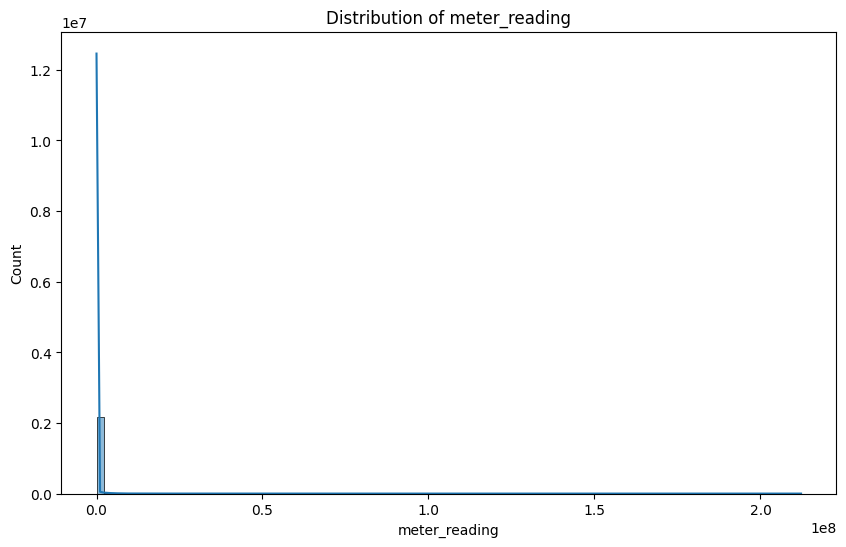

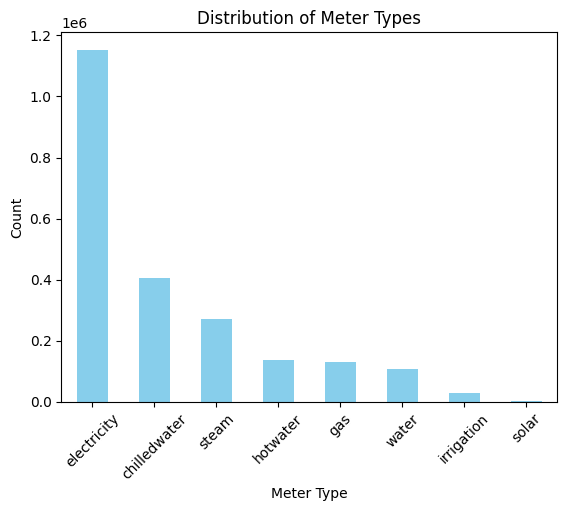

In [24]:
# Distribution of numerical features
for column in ['meter_reading']:
    plt.figure(figsize=(10, 6))
    sns.histplot(meter_reading[column], bins=100, kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()


# Check the meter counts 
meter_counts = meter_reading["meter"].value_counts()

# Plot the results
meter_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Meter Types')
plt.xlabel('Meter Type')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.show()


The histogram shows the distribution of meter readings, where the majority of the readings are clustered near zero, indicating a highly skewed distribution. There is an extremely low frequency of readings as the meter reading value increases, which suggests that high meter readings are rare or outliers. The y-axis, representing the count, is quite low across the board, which further emphasizes the concentration of smaller values. 

The most popular meter type is electricity, followed by chilledwater. The least common meter type is solar.

## Bivaraite Analysis 

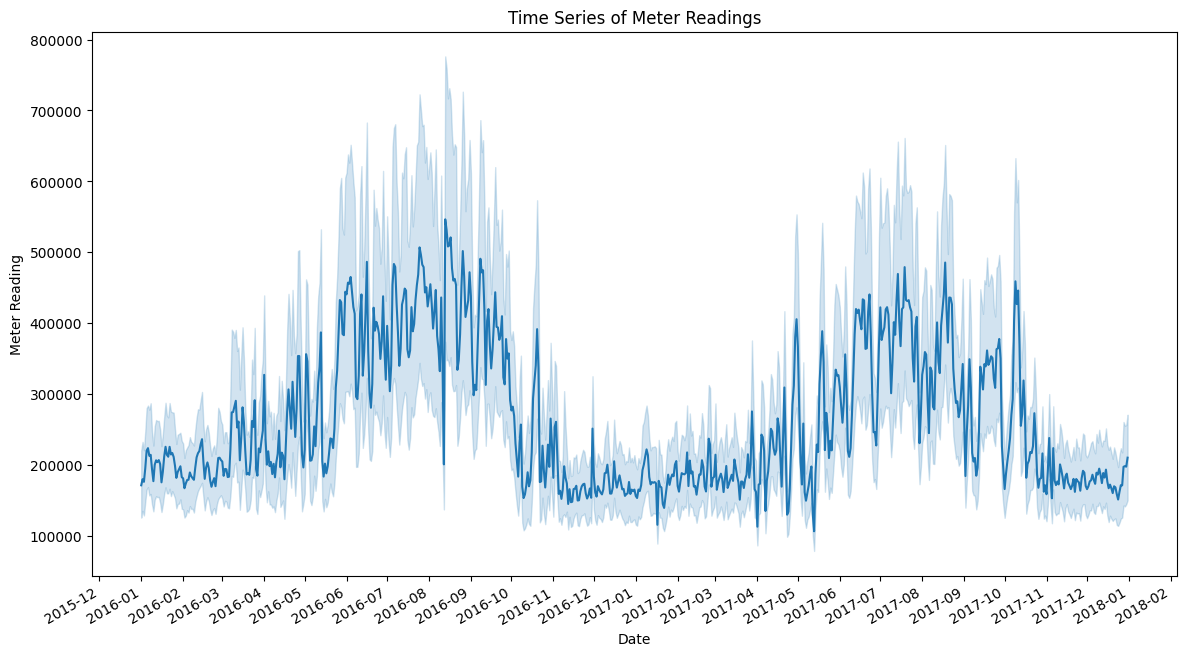

/var/folders/20/6gd3bgbx1kn0xfsyzbfxk8nm0000gn/T/ipykernel_20297/3548974062.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha="right", fontsize=10)  # Adjust fontsize as needed


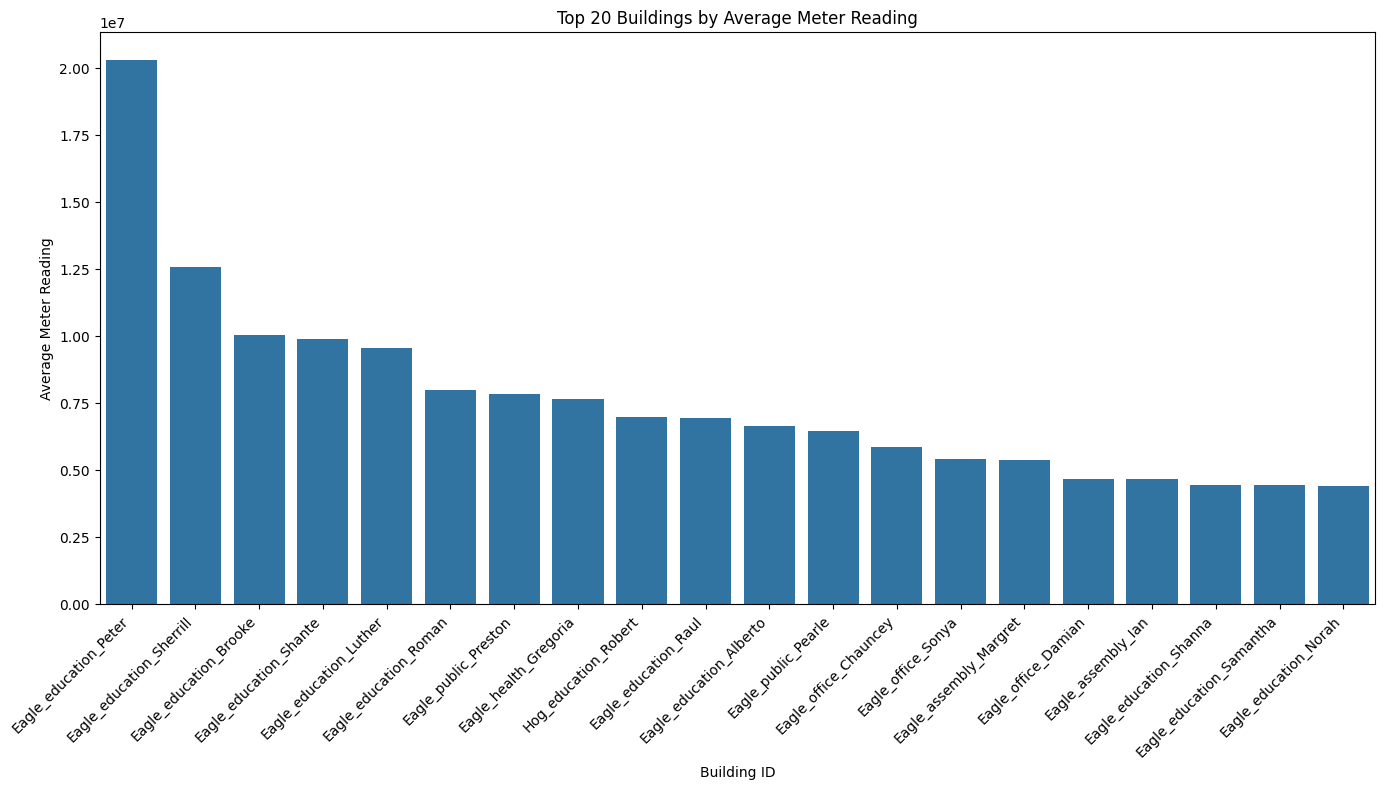

/Users/sameeraboppana/work_env/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


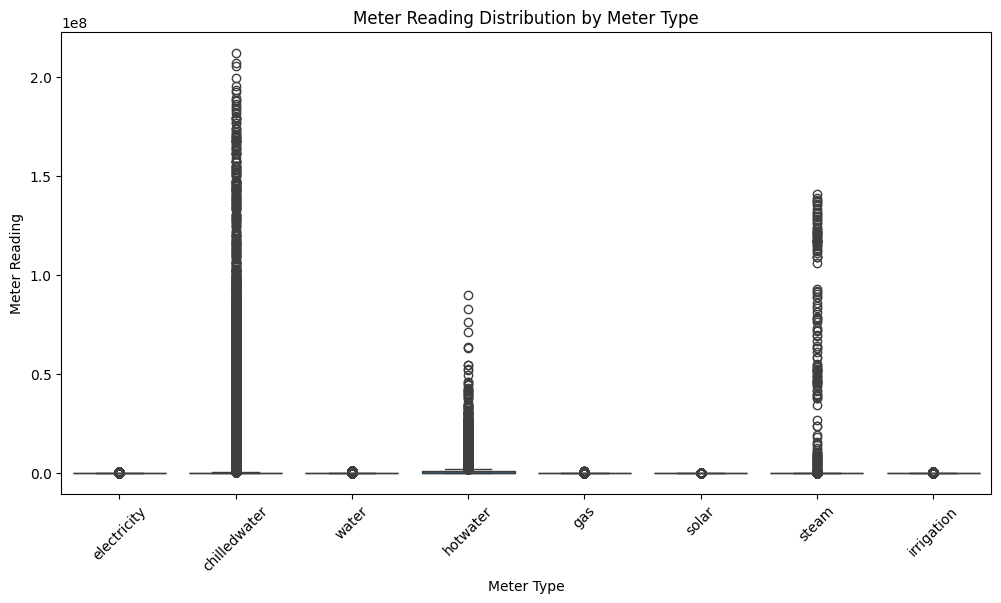

In [27]:
# Time series plot for meter readings over time
plt.figure(figsize=(14, 8))  
sns.lineplot(x='date', y='meter_reading', data=meter_reading)

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as Year-meter_reading
plt.gca().xaxis.set_major_locator(mdates.meter_readingLocator())  # Set major ticks to meter_readingly intervals

# Improve the tick labels
plt.gcf().autofmt_xdate()  # Auto-format the date labels
plt.title('Time Series of Meter Readings')
plt.xlabel('Date')
plt.ylabel('Meter Reading')

plt.show()


# Average Meter Reading vs. Building ID
# Calculate average meter readings for each building
average_readings_by_building = meter_reading.groupby('building_id')['meter_reading'].mean().reset_index()

# Sort the buildings by average meter reading in descending order and select the top 20
top_buildings = average_readings_by_building.sort_values(by='meter_reading', ascending=False).head(20)

# Plotting the average meter readings for the top 20 buildings
plt.figure(figsize=(14, 8))  
barplot = sns.barplot(data=top_buildings, x='building_id', y='meter_reading')
plt.title('Top 20 Buildings by Average Meter Reading')
plt.xlabel('Building ID')
plt.ylabel('Average Meter Reading')

# Rotate the x-axis labels for better readability
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, ha="right", fontsize=10)  # Adjust fontsize as needed
plt.tight_layout()
plt.show()

# Bivariate Analysis 3: Meter Reading Distribution by Meter Type
# This is relevant if you have different meter types
plt.figure(figsize=(12, 6))
sns.boxplot(data=meter_reading, x='meter', y='meter_reading')
plt.title('Meter Reading Distribution by Meter Type')
plt.xlabel('Meter Type')
plt.ylabel('Meter Reading')
plt.xticks(rotation=45)
plt.show()


The time series graph displays the meter readings over a period from January 2016 to February 2017. The data exhibits significant fluctuations and a few noticeable peaks, suggesting that there may be periodic trends or that certain times have unusually high readings. The confidence interval (shaded area) suggests variability in the readings over time, with some periods having a wider range of readings. The overall trend appears to show some seasonality, as indicated by the repeating patterns of peaks and troughs, which could be associated with operational cycles or seasonal usage patterns of the facility or equipment being measured.

The first building, 'Eagle_education_Peter', has significantly higher average meter readings compared to the others, suggesting it may have higher energy consumption or operational demands. The buildings with the highest energy consumption predominantly belong to the 'Eagle_education' category, suggesting these types of buildings might typically have higher energy requirements, or it could reflect a specific subset of your dataset where these buildings are overrepresented.

This boxplot shows the distribution of meter readings across different types of meters such as 'electricity', 'chilledwater', 'hotwater', etc. The 'electricity' and 'chilledwater' meter types exhibit significant outliers with extremely high readings compared to other types, as indicated by the points above the main body of the boxplot. This suggests variability in usage or potential issues with meter readings such as spikes or data entry errors. Most meter types show a concentration of readings near the lower end of the scale, but 'electricity' and 'chilledwater' have wider distributions, indicating a broader range of consumption values. The 'steam' meter type also shows a higher median compared to others like 'hotwater' and 'water', which might suggest generally higher usage levels or different operational characteristics associated with those meter types.

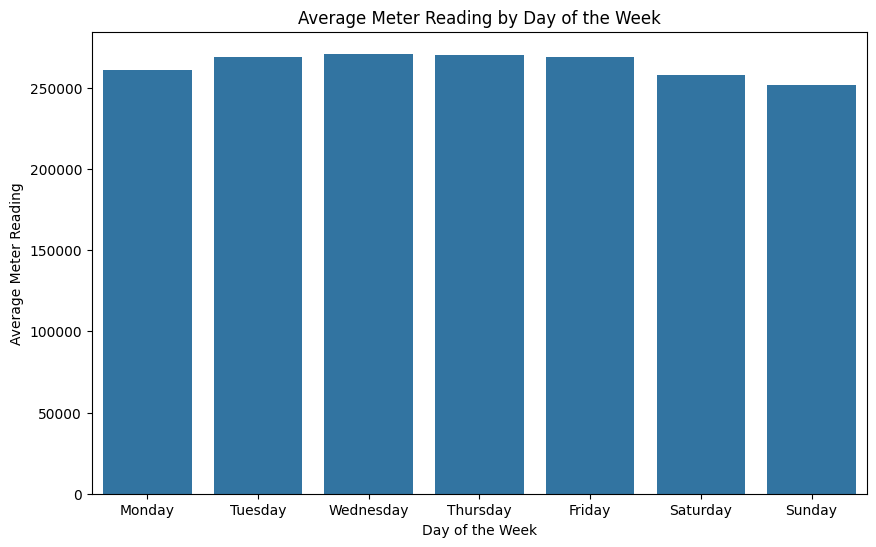

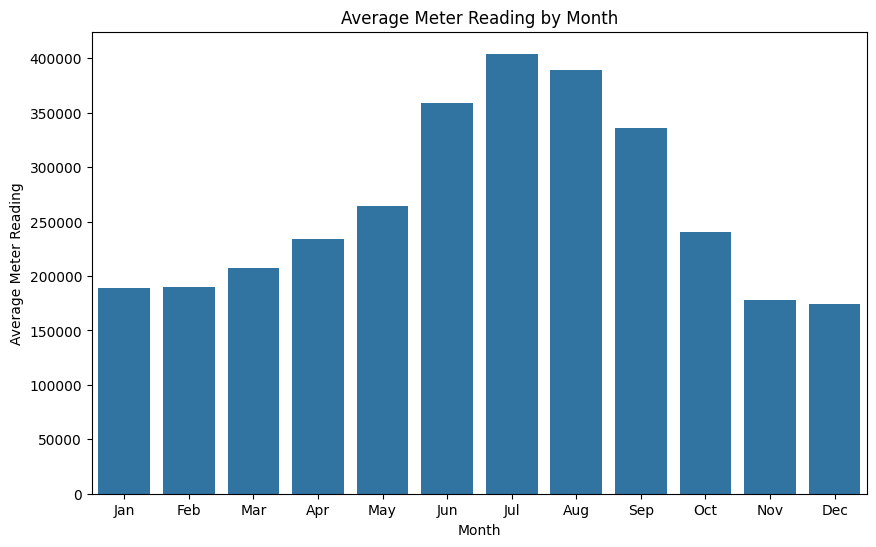

In [28]:


# Extract day of week, month, and hour (if time is available)
meter_reading['day_of_week'] = meter_reading['date'].dt.day_name()
meter_reading['month'] = meter_reading['date'].dt.month

# Aggregate average meter readings by day of the week
avg_by_day = meter_reading.groupby('day_of_week')['meter_reading'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot average meter readings by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_by_day.index, y=avg_by_day.values)
plt.title('Average Meter Reading by Day of the Week')
plt.ylabel('Average Meter Reading')
plt.xlabel('Day of the Week')
plt.show()

# Aggregate average meter readings by month
avg_by_month = meter_reading.groupby('month')['meter_reading'].mean()

# Plot average meter readings by month
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_by_month.index, y=avg_by_month.values)
plt.title('Average Meter Reading by Month')
plt.ylabel('Average Meter Reading')
plt.xlabel('Month')
plt.xticks(ticks=range(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


There does not seem to be much variation of meter readings by data. 

THere seems to be an increase in energy consumption in the summer months. This can indicate that when it is warmer there is higher energy consumption;